In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load synthetic data
data = pd.read_csv('cogni_synthetic_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   OrgType           1000 non-null   object
 1   TeamSize          1000 non-null   object
 2   ClientVolume      1000 non-null   object
 3   ServiceModel      1000 non-null   object
 4   Specialization    1000 non-null   object
 5   Timeline          1000 non-null   object
 6   Features          1000 non-null   object
 7   Package           1000 non-null   object
 8   RecommendedSeats  1000 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 70.4+ KB


In [4]:
data.describe()

,RecommendedSeats
count,1000.000000
mean,21.908000
std,21.755754
min,2.000000
25%,5.000000
50%,12.000000
75%,37.000000
max,75.000000


In [5]:
# Encoding all categorical features
encoders = {}
encoded_features = []

for col in ['OrgType', 'TeamSize', 'ClientVolume', 'ServiceModel', 'Specialization', 'Timeline', 'Features']:
    encoders[col] = LabelEncoder()
    data[f'{col}_enc'] = encoders[col].fit_transform(data[col])
    encoded_features.append(f'{col}_enc')

# Package encoder
package_encoder = LabelEncoder()
data['Package_enc'] = package_encoder.fit_transform(data['Package'])

In [6]:
# Preparing features and target
X = data[encoded_features]
y = data['Package_enc']

In [7]:
# Split data into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,  # Increase for convergence
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss'
    )
}

In [9]:
# Train, predict, and evaluate each model
results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, target_names=package_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'report': report,
        'confusion_matrix': cm
    }
    
    # Print results
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)


=== Logistic Regression ===
Accuracy: 0.5850
F1-Score: 0.5762

Classification Report:
                   precision    recall  f1-score   support

 Community Access       0.53      0.65      0.58        72
Enterprise Access       0.56      0.57      0.57        61
  Enterprise Care       1.00      1.00      1.00        20
      Fresh Start       0.00      0.00      0.00         2
    Practice Plus       0.54      0.33      0.41        45

         accuracy                           0.58       200
        macro avg       0.53      0.51      0.51       200
     weighted avg       0.58      0.58      0.58       200


=== Random Forest ===
Accuracy: 0.9750
F1-Score: 0.9746

Classification Report:
                   precision    recall  f1-score   support

 Community Access       0.95      1.00      0.97        72
Enterprise Access       0.98      1.00      0.99        61
  Enterprise Care       1.00      1.00      1.00        20
      Fresh Start       1.00      1.00      1.00         2
  

In [10]:
summary_data = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [f"{v['accuracy']:.4f}" for v in results.values()],
    'F1-Score': [f"{v['f1_score']:.4f}" for v in results.values()]
})

Text(0, 0.5, 'Score')

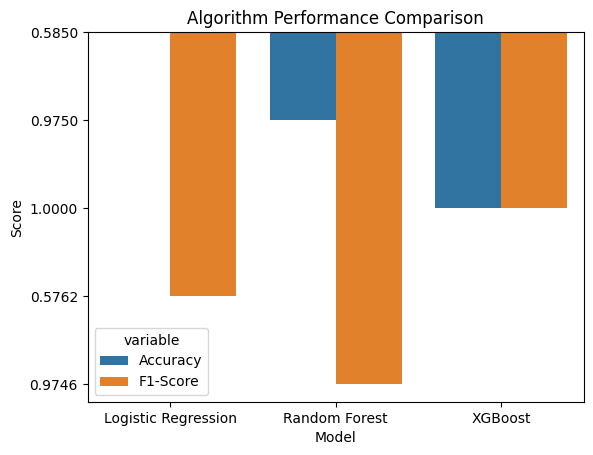

In [11]:
sns.barplot(data=summary_data.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Algorithm Performance Comparison")
plt.ylabel("Score")

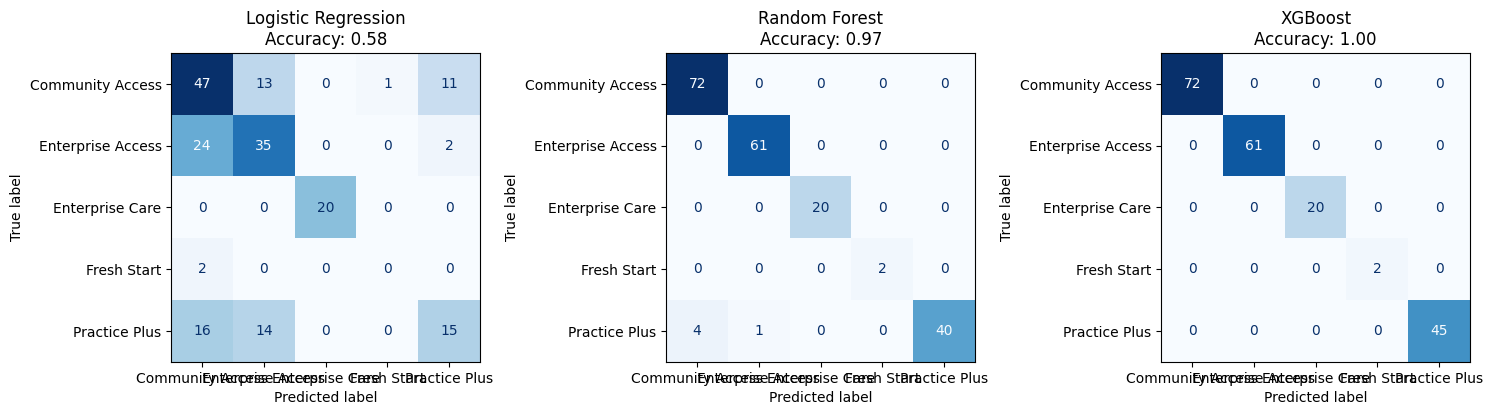

In [12]:
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items()):
    # Plot confusion matrix
    plt.subplot(1, 3, i + 1)
    cm = confusion_matrix(y_test, result['model'].predict(X_test))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=package_encoder.classes_
    )
    disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
    plt.title(f"{name}\nAccuracy: {result['accuracy']:.2f}")

plt.tight_layout()
plt.show()

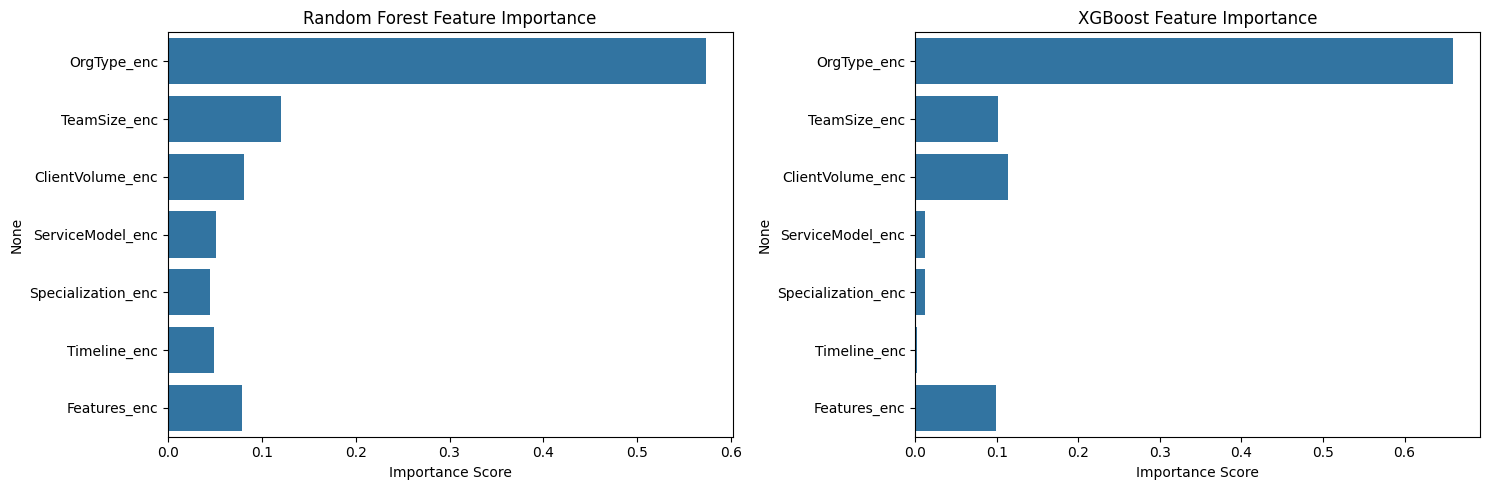

In [13]:
# Plot feature importance for tree-based models
plt.figure(figsize=(15, 5))

for i, (name, result) in enumerate(results.items()):
    if name in ["Random Forest", "XGBoost"]:  # Only plot for tree-based models
        plt.subplot(1, 2, i)
        if name == "Random Forest":
            importances = result['model'].feature_importances_
        else:  # XGBoost
            importances = result['model'].feature_importances_
        
        feature_names = X.columns
        sns.barplot(x=importances, y=feature_names)
        plt.title(f"{name} Feature Importance")
        plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()

In [14]:
# Print the best model based on F1-score
best_model = max(results.items(), key=lambda x: x[1]['f1_score'])
print(f"\n*** Best Model: {best_model[0]} (F1-Score: {best_model[1]['f1_score']:.4f}) ***")


*** Best Model: XGBoost (F1-Score: 1.0000) ***


In [16]:
print(data['Package'].value_counts())

Package
Community Access     365
Enterprise Access    313
Practice Plus        169
Enterprise Care      142
Fresh Start           11
Name: count, dtype: int64
